# compare binary classification to continuous scoring

## install packages & load data

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pickle
import scipy
import pandas as pd
from scipy import stats
from scipy.stats import normaltest
import matplotlib as mpl
import itertools
from itertools import groupby

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import warnings
warnings.simplefilter('ignore', pd.errors.DtypeWarning)
np.seterr(divide='ignore')
warnings.simplefilter("ignore")

import analysis.calc_single_cell_properties as calculator 
import analysis.utils as utils
import data_layer.utils as data_utils
import model_layer.build_model as build_model

from configuration import consts, params

To evaluate the significance of using a continuous readout, we propose to examine the distribution of: 
1. the predicted time of the differentiation process. 
2. the duration between predicted terminal differentiation and fusion. 

We will assess these distributions based on the differentiation score, comparing results obtained by: 
1. incorporating the continuous differentiation score throughout each cells’ trajectory 
2. using a binary differentiation state (undifferentiated/differentiated), according to differentiation score thresholding, throughout each cells’ trajectory. 

We will then compare the single-cell time distributions. Our hypothesis is that, when using a binary differentiation score, the distribution will exhibit greater variability compared to the case of the continuous score, due to increased measurement “noise”. This would provide more evidence that the continuous differentiation score offers valuable insights for studying ongoing biological processes.


In [ ]:
def get_binary_scores(scores_df, threshold=0.5):
    # tranfrorm scores into binary scores (1 = differentiated; 0 = undifferentiated)
    scores_df["score_motility_binary"] = scores_df["score_motility"].apply(lambda x: 1 if x>=threshold else 0)
    scores_df["score_intensity_binary"] = scores_df["score_intensity"].apply(lambda x: 1 if x>=threshold else 0)
    return scores_df

In [ ]:
# get binary scores for fused data
scores_df_s3_fused = data_utils.get_scores_df_with_fusion()
scores_df_s3_fused = get_binary_scores(scores_df_s3_fused, 0.7)
scores_df_s3_fused.head(3)

In [ ]:
# get binary scores for all S3's data
scores_df_s3_all = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S3.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S3.pkl")
scores_df_s3_all = get_binary_scores(scores_df_s3_all, 0.7)
scores_df_s3_all.head(3)

In [ ]:
# get binary scores for all S2's data
scores_df_s2_all = data_utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S2.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S2.pkl")
scores_df_s2_all = get_binary_scores(scores_df_s2_all, 0.7)
scores_df_s2_all.head(3)

## examine the binary model on the global population

#### plot mean & std of the differentiation scores

In [ ]:
data_2_3_test  = [(scores_df_s3_all, "ERKi", "DarkOrange","Orange"), (scores_df_s2_all, "DMSO", "blue", "blue"),]
utils.plot_avg_conf(data_2_3_test, "motility_binary", path="", plot_std=True, time=(6,13), xlim=(2.5, 17))
utils.plot_avg_conf(data_2_3_test, "intensity_binary", path="", plot_std=True, time=(6,13), xlim=(2.5, 17))

#### Show the distribution of terminal differentiation timing

((0.2, 0.3), (0.7, 0.8))
((0, 0.5), (0.5, 1))
((0.2, 0.3), (0.7, 0.8))
((0, 0.5), (0.5, 1))
number of cells in the analysis: 71
motility: normality test p-val=0.06332330386401003, mean: 4.266, std: 3.008, median: 3.5, percentage >=0: 71.831 %
motility_binary: normality test p-val=3.0180087372783744e-05, mean: 3.129, std: 3.349, median: 1.833, percentage >=0: 100.0 %
intensity: normality test p-val=0.15718660737811616, mean: 5.613, std: 3.21, median: 5.083, percentage >=0: 83.099 %
intensity_binary: normality test p-val=0.0031108196037002486, mean: 4.418, std: 3.78, median: 3.417, percentage >=0: 100.0 %


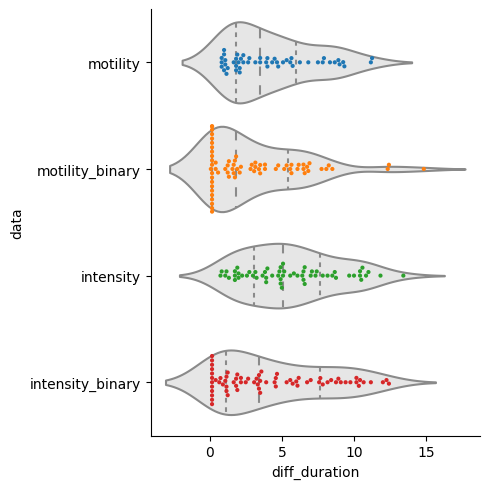

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


number of cells in the analysis: 71
motility: normality test p-val=0.3661727863740763, mean: 12.02, std: 2.743, median: 11.25, percentage >=0: 80.282 %
motility_binary: normality test p-val=0.48803969558247984, mean: 11.927, std: 2.704, median: 12.083, percentage >=0: 83.099 %
intensity: normality test p-val=0.7190519670635068, mean: 12.711, std: 2.64, median: 12.833, percentage >=0: 71.831 %
intensity_binary: normality test p-val=0.8005072096143766, mean: 12.103, std: 2.581, median: 11.958, percentage >=0: 84.507 %


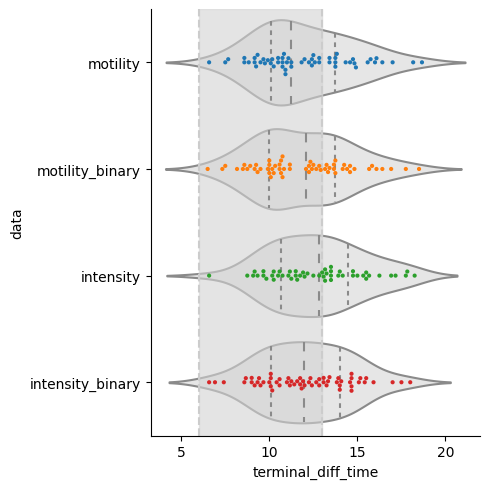

number of cells in the analysis: 71
motility: normality test p-val=0.044913768804142724, mean: 3.722, std: 2.352, median: 3.083, percentage >=0: 80.282 %
motility_binary: normality test p-val=0.10801461205378389, mean: 3.75, std: 2.443, median: 3.333, percentage >=0: 81.69 %
intensity: normality test p-val=0.17726040145081245, mean: 3.047, std: 1.879, median: 3.0, percentage >=0: 69.014 %
intensity_binary: normality test p-val=0.07099688072519689, mean: 3.521, std: 2.177, median: 3.292, percentage >=0: 83.099 %


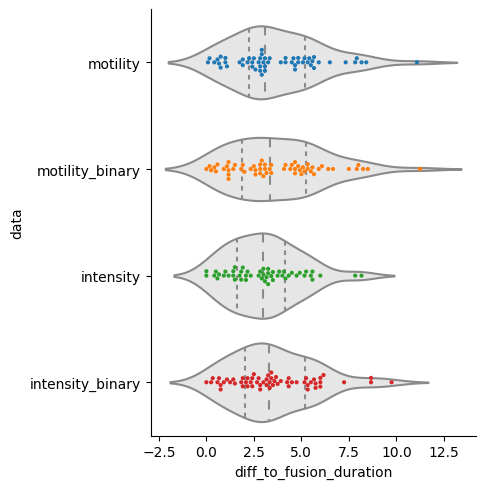

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


number of cells in the analysis: 71
motility: normality test p-val=0.7703558613656544, mean: 9.992, std: 3.118, median: 10.167, percentage >=0: 71.831 %
motility_binary: normality test p-val=0.08146478729407579, mean: 10.547, std: 3.616, median: 9.833, percentage >=0: 100.0 %
intensity: normality test p-val=0.38139746422339754, mean: 10.254, std: 3.222, median: 9.75, percentage >=0: 83.099 %
intensity_binary: normality test p-val=0.18937685633928417, mean: 10.635, std: 2.962, median: 10.25, percentage >=0: 100.0 %


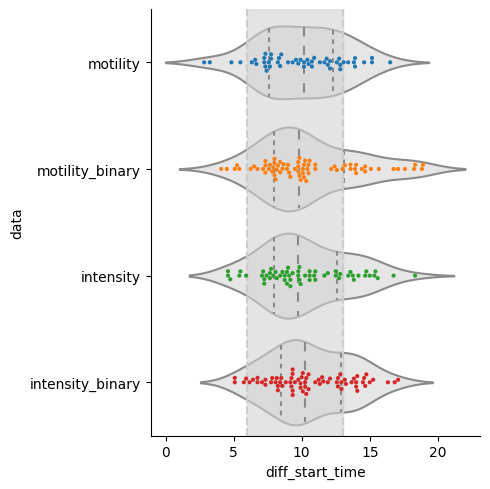

In [13]:
modalities = ["motility", "motility_binary", "intensity", "intensity_binary"]

def get_binary_diff_start_time(scores_df, modality):
    
    def calc_binary_diff_start_time(track, modality):
        initial_time_point = track.dropna(subset=f"score_{modality}")["time"].min()
        return initial_time_point

    binary_diff_start_time = scores_df.groupby(['Spot track ID']).apply(lambda x: calc_binary_diff_start_time(x, modality))
    scores_df[f"diff_start_time_{modality}"] = scores_df.groupby(['Spot track ID'])['Spot track ID'].transform(lambda x: binary_diff_start_time[x.iloc[0]])

    return scores_df

def get_binary_diff_duration(scores_df, modality):    
    def calc_diff_duration(track, modality, high_thresh):
        high_thresh_time = calculator.get_stable_threshold_time(track, high_thresh, modality, time_point="first")
        low_thresh_time = track[f"diff_start_time_{modality}"].min()
        duration = high_thresh_time - low_thresh_time
        return duration

    duration_lst = scores_df.groupby(['Spot track ID']).apply(lambda x: calc_diff_duration(x, modality, (0.5, 1)))
    scores_df[f"diff_duration_{modality}"] = scores_df.groupby(['Spot track ID'])['Spot track ID'].transform(lambda x: duration_lst[x.iloc[0]])

    return scores_df

# (low_thresh, high_thresh) = ((0.2, 0.3), (0.7, 0.8))
for modality in modalities:
    scores_df_s3_fused = calculator.get_terminal_diff_time(scores_df_s3_fused, modality, 0.78)
    scores_df_s3_fused = calculator.get_differentiation_fusion_duration(scores_df_s3_fused, modality)
    
    (low_thresh, high_thresh) = ((0, 0.5), (0.5, 1)) if "binary" in modality else ((0.2, 0.3), (0.7, 0.8))
    print((low_thresh, high_thresh))
    scores_df_s3_fused = calculator.get_diff_duration(scores_df_s3_fused, modality, low_thresh, high_thresh)
    scores_df_s3_fused = calculator.get_diff_start_time(scores_df_s3_fused, modality, low_thresh, high_thresh)
    
#     if "binary" in modality:
#         scores_df_s3_fused = get_binary_diff_start_time(scores_df_s3_fused, modality)
#         scores_df_s3_fused = get_binary_diff_duration(scores_df_s3_fused, modality)
        
#     else:
#         scores_df_s3_fused = calculator.get_diff_duration(scores_df_s3_fused, modality, low_thresh, high_thresh)
#         scores_df_s3_fused = calculator.get_diff_start_time(scores_df_s3_fused, modality, low_thresh, high_thresh)

data_to_plot = scores_df_s3_fused.drop_duplicates("Spot track ID")
modalities = ["motility", "motility_binary", "intensity", "intensity_binary"]

utils.plot_violin_distributions(data_to_plot, "diff_duration", modalities)
utils.plot_violin_distributions(data_to_plot, "terminal_diff_time", modalities, plot_window=True)
utils.plot_violin_distributions(data_to_plot, "diff_to_fusion_duration", modalities) 
utils.plot_violin_distributions(data_to_plot, "diff_start_time", modalities, plot_window=True)

number of cells in the analysis: 675
motility: normality test p-val=6.699356223938382e-08, mean: 4.804, std: 3.299, median: 4.083, percentage >=0: 62.963 %
motility_binary: normality test p-val=7.988477616994372e-33, mean: 2.304, std: 2.853, median: 0.833, percentage >=0: 95.259 %
intensity: normality test p-val=4.4658876253461547e-10, mean: 6.064, std: 3.685, median: 5.542, percentage >=0: 73.481 %
intensity_binary: normality test p-val=9.364706493981542e-16, mean: 3.177, std: 3.178, median: 2.333, percentage >=0: 98.222 %


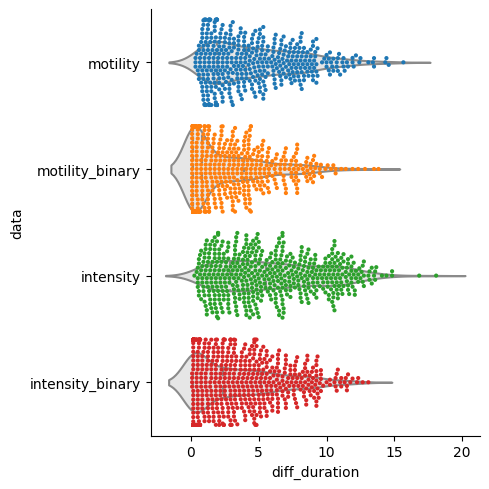

number of cells in the analysis: 675
motility: normality test p-val=6.4617340684246e-08, mean: 9.858, std: 3.338, median: 9.333, percentage >=0: 62.963 %
motility_binary: normality test p-val=1.959230204338147e-09, mean: 11.053, std: 3.532, median: 10.5, percentage >=0: 95.259 %
intensity: normality test p-val=3.330183667456073e-13, mean: 9.303, std: 2.957, median: 8.833, percentage >=0: 73.481 %
intensity_binary: normality test p-val=1.241090789699651e-06, mean: 11.321, std: 3.117, median: 10.917, percentage >=0: 98.222 %


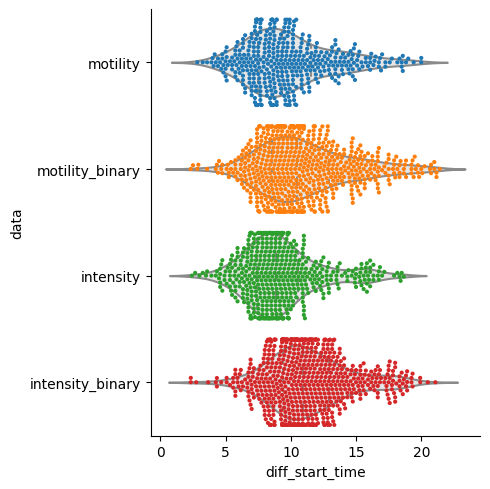

In [15]:
# repeat for all S3's data
modalities = ["motility", "motility_binary", "intensity", "intensity_binary"]

for modality in modalities:    
    (low_thresh, high_thresh) = ((0, 0.5), (0.5, 1)) if "binary" in modality else ((0.2, 0.3), (0.7, 0.8))
    scores_df_s3_all = calculator.get_diff_duration(scores_df_s3_all, modality, low_thresh, high_thresh)
    scores_df_s3_all = calculator.get_diff_start_time(scores_df_s3_all, modality, low_thresh, high_thresh)
    
#     if "binary" in modality:
#         scores_df_s3_all = get_binary_diff_start_time(scores_df_s3_all, modality)
#         scores_df_s3_all = get_binary_diff_duration(scores_df_s3_all, modality)
        
#     else:
#         scores_df_s3_all = calculator.get_diff_duration(scores_df_s3_all, modality, low_thresh, high_thresh)
#         scores_df_s3_all = calculator.get_diff_start_time(scores_df_s3_all, modality, low_thresh, high_thresh)

scores_df_s3_all.head()

data_to_plot = scores_df_s3_all.drop_duplicates(subset=["Spot track ID"])
utils.plot_violin_distributions(data_to_plot, "diff_duration", modalities)
utils.plot_violin_distributions(data_to_plot, "diff_start_time", modalities)

## examine the binary model in the single cell level

#### plot sample of single cells differentiation trajectory by binary/continuous scores

In [ ]:
track_ids = [27879, 4657, 16003, 16771, 16991.0, 10528.0, 16348.0, 10879.0, 6993.0]
modalities = ["motility", "intensity", "motility_binary", "intensity_binary"]
dir_path = consts.storage_path +"eps_figs/single_cell_trajectories_binary_continuous"
os.makedirs(dir_path, exist_ok=True)

for track_id in track_ids:
    print(track_id)
    for modality in modalities:
        track = scores_df_s3_fused[scores_df_s3_fused["Spot track ID"].isin([track_id])]
        track = track[track["Spot frame"]<=track["fusion_frame"]]
        plotting_data = [(track, "ERK")]
        saving_path =  dir_path + f"/single_cell_traj_{modality}_{track_id}.eps"
        utils.plot_diff_trajectories_single_cells(plotting_data, modality, dir_path , rolling_w=1)

In [ ]:
scores_df_s3_all = calculator.get_properties(scores_df_s3_all, vid_name="S3", actin_vid_path=consts.s_runs["3"]['actin_path'])
scores_df_s3_fused = scores_df_s3_fused.merge(scores_df_s3_all, how="left", on=["Spot track ID", "Spot frame", "time", "score_motility", "score_intensity", 'Spot position X', 'Spot position Y' ])

In [ ]:
scores_df_s3_fused.columns

In [ ]:
def get_mean_properties_in_range(track, feature, my_range):
    track = track[(track[feature] >= my_range[0]) & (track[feature] <= my_range[1])]
    track = track[[f"score_motility","score_intensity", "speed", "mean", "persistence", "local density", "time"]]
    mean_values_df = pd.DataFrame(track.mean()).T
    mean_values_df["range"] = str(my_range)
    return mean_values_df
 

def plot_props_by_range(track, feature_name, ranges):
    track = track[track["Spot frame"]<=track["fusion_frame"]]
    
    df = pd.DataFrame()
    for my_range in ranges:
        data = get_mean_properties_in_range(track, feature_name, my_range)
        df = df.append(data, ignore_index=True)
    
    for subplot_n, col in zip(np.arange(611, 616), ["time", "speed", "mean", "persistence", "local density"]):
        ax = plt.subplot(subplot_n)
        ax.plot(df["range"], df[col],  linestyle='--', marker='o', label=col)
        plt.legend(loc='lower right')
        ax.set_yticks((round(df[col].min()), round(df[col].max())))
    
    plt.show()

In [ ]:
track_id = 27879
print(track_id, modality)
motility_score_ranges = [(0, 0.2), (0.2, 0.6), (0.6, 0.7), (0.7, 1)]

track = scores_df_s3_fused[scores_df_s3_fused["Spot track ID"]==track_id]
plot_props_by_range(track, "score_motility", motility_score_ranges)

print(track_id, modality)
intensity_score_ranges = [(0, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1)]
plot_props_by_range(track, "score_intensity", intensity_score_ranges)

In [ ]:
track_id = 16003
modality = "motility"
print(track_id, modality)
motility_score_ranges = [(0, 0.1), (0.1, 0.6), (0.6, 0.8), (0.8, 1)]

track = scores_df_s3_fused[scores_df_s3_fused["Spot track ID"]==track_id]
plot_props_by_range(track, "score_motility", motility_score_ranges)

modality = "intensity"
print(track_id, modality)
intensity_score_ranges = [(0, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1)]
plot_props_by_range(track, "score_intensity", intensity_score_ranges)